In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

# INCREASE MNIST MODEL TO REACH AT LEAST 97%

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets("../data/mnist", one_hot=True)

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


In [4]:
import time

In [18]:
tf.reset_default_graph()

N_CLASSES = 10

# Step 2: Define paramaters for the model
LEARNING_RATE = 0.01
BATCH_SIZE = 64
SKIP_STEP = 10
DROPOUT = 0.80
N_EPOCHS = 10


with tf.name_scope('data'):
    X = tf.placeholder(tf.float32, [None, 784], name="X_placeholder")
    Y = tf.placeholder(tf.float32, [None, 10], name="Y_placeholder")

dropout = tf.placeholder(tf.float32, name='dropout')


global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')



with tf.variable_scope('conv1') as scope:
    
    images = tf.reshape(X, shape=[-1, 28, 28, 1])
    
    
    
    kernel = tf.get_variable('kernel', shape=[5, 5, 1, 32], initializer=tf.truncated_normal_initializer())
    
   
    
    biases = tf.get_variable('biases', shape=[32], initializer=tf.constant_initializer(0.0))
    
   
    conv = tf.nn.conv2d(images, kernel, strides=[1, 1, 1, 1], padding='SAME')
    
   
    conv1 = tf.nn.relu(conv + biases, name='conv1')
    
    
    
with tf.variable_scope('pool1') as scope:
   
    
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], name='pool1', strides=[1, 2, 2, 1], padding='SAME')

    

with tf.variable_scope('conv2') as scope:

    kernel = tf.get_variable('kernels', [5, 5, 32, 64], 
                        initializer=tf.truncated_normal_initializer())
    biases = tf.get_variable('biases', [64],
                        initializer=tf.random_normal_initializer())
    conv = tf.nn.conv2d(pool1, kernel, strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(conv + biases, name=scope.name)


with tf.variable_scope('pool2') as scope:

    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                            padding='SAME')

   
    

with tf.variable_scope('fc') as scope:

    input_features = 7 * 7 * 64
    
   
    w = tf.get_variable('weights', shape=[input_features, 1024], initializer=tf.truncated_normal_initializer())
    b = tf.get_variable('bias', shape=[1024], initializer=tf.constant_initializer(0.0))

    pool2 = tf.reshape(pool2, [-1, input_features])

    fc = tf.nn.relu(tf.matmul(pool2, w) + b, name='relu')
    
   
    fc = tf.nn.dropout(fc, dropout, name='relu_dropout')

with tf.variable_scope('softmax_linear') as scope:
    
    w = tf.get_variable('weights', shape=[1024, N_CLASSES], initializer=tf.truncated_normal_initializer())
    b = tf.get_variable('bias', shape=[N_CLASSES], initializer=tf.constant_initializer(0.0))
    
    logits = tf.matmul(fc, w) + b


    
with tf.name_scope('loss'):
   
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits), name='loss')



optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss, global_step=global_step)

with tf.name_scope('summary'):
    tf.summary.scalar('loss', loss)
    summary_op = tf.summary.merge_all()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()

    writer = tf.summary.FileWriter('./my_graph/mnist', sess.graph)
   
    
    initial_step = global_step.eval()

    start_time = time.time()
    n_batches = int(mnist.train.num_examples / BATCH_SIZE)

    total_loss = 0.0
    for index in range(initial_step, n_batches * N_EPOCHS): # train the model n_epochs times
        X_batch, Y_batch = mnist.train.next_batch(BATCH_SIZE)
        _, loss_batch, summary = sess.run([optimizer, loss, summary_op], 
                                feed_dict={X: X_batch, Y:Y_batch, dropout: DROPOUT}) 
        total_loss += loss_batch
        writer.add_summary(summary, global_step=index)
        if (index + 1) % SKIP_STEP == 0:
            print('Average loss at step {}: {:5.1f}'.format(index + 1, total_loss / SKIP_STEP))
            total_loss = 0.0
            saver.save(sess, '../checkpoints/convnet_mnist/mnist-convnet', index)
    
    print("Optimization Finished!") # should be around 0.35 after 25 epochs
    print("Total time: {0} seconds".format(time.time() - start_time))
    
    # test the model
    n_batches = int(mnist.test.num_examples/BATCH_SIZE)
    total_correct_preds = 0
    for i in range(n_batches):
        X_batch, Y_batch = mnist.test.next_batch(BATCH_SIZE)
        _, loss_batch, logits_batch = sess.run([optimizer, loss, logits], 
                                        feed_dict={X: X_batch, Y:Y_batch, dropout: DROPOUT}) 
        preds = tf.nn.softmax(logits_batch)
        correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y_batch, 1))
        accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))
        total_correct_preds += sess.run(accuracy)   
    
    print("Accuracy {0}".format(total_correct_preds/mnist.test.num_examples))

Average loss at step 10: 49462.9
Average loss at step 20: 6585.9
Average loss at step 30: 1948.9
Average loss at step 40: 1246.3
Average loss at step 50: 848.3
Average loss at step 60: 555.2
Average loss at step 70: 460.3
Average loss at step 80: 434.5
Average loss at step 90: 376.0
Average loss at step 100: 298.7
Average loss at step 110: 288.6
Average loss at step 120: 290.7
Average loss at step 130: 201.3
Average loss at step 140: 140.2
Average loss at step 150: 186.7
Average loss at step 160: 167.9
Average loss at step 170: 128.4
Average loss at step 180: 188.6
Average loss at step 190: 195.5
Average loss at step 200: 117.7
Average loss at step 210: 140.7
Average loss at step 220: 167.2
Average loss at step 230: 188.0
Average loss at step 240: 140.5
Average loss at step 250: 161.8
Average loss at step 260: 141.8
Average loss at step 270: 169.2
Average loss at step 280: 130.6
Average loss at step 290: 149.6
Average loss at step 300: 118.7
Average loss at step 310: 111.7
Average loss

## (10 epochs) two conv nets then one fc with relu and dropout -> Accuracy 0.9665 - 0.9672 - 0.97

In [16]:
mnist.train.images.shape, mnist.test.images.shape

((55000, 784), (10000, 784))

In [25]:
tf.reset_default_graph()

N_CLASSES = 10

# Step 2: Define paramaters for the model
LEARNING_RATE = 0.01
BATCH_SIZE = 64
SKIP_STEP = 10
DROPOUT = 0.80
N_EPOCHS = 10


with tf.name_scope('data'):
    X = tf.placeholder(tf.float32, [None, 784], name="X_placeholder")
    Y = tf.placeholder(tf.float32, [None, 10], name="Y_placeholder")

dropout = tf.placeholder(tf.float32, name='dropout')

global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')


with tf.variable_scope('fc0') as scope:
    
    w = tf.get_variable('weights', shape=[784, 1024], initializer=tf.truncated_normal_initializer())
    b = tf.get_variable('bias', shape=[1024], initializer=tf.constant_initializer(0.0))
    
    fc0 = tf.cos(tf.add(tf.matmul(X, w), b))
    

with tf.variable_scope('conv1') as scope:
    
    images = tf.reshape(fc0, shape=[-1, 32, 32, 1])
    
    
    kernel = tf.get_variable('kernel', shape=[5, 5, 1, 32], initializer=tf.truncated_normal_initializer())
    
   
    
    biases = tf.get_variable('biases', shape=[32], initializer=tf.constant_initializer(0.0))
    
   
    conv = tf.nn.conv2d(images, kernel, strides=[1, 1, 1, 1], padding='SAME')
    
   
    conv1 = tf.nn.relu(conv + biases, name='conv1')
    
    
    
with tf.variable_scope('pool1') as scope:
   
    
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], name='pool1', strides=[1, 2, 2, 1], padding='SAME')

    

with tf.variable_scope('conv2') as scope:

    kernel = tf.get_variable('kernels', [5, 5, 32, 64], 
                        initializer=tf.truncated_normal_initializer())
    biases = tf.get_variable('biases', [64],
                        initializer=tf.random_normal_initializer())
    conv = tf.nn.conv2d(pool1, kernel, strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(conv + biases, name=scope.name)


with tf.variable_scope('pool2') as scope:

    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                            padding='SAME')

   
    

with tf.variable_scope('fc') as scope:

    input_features = 8 * 8 * 64
    
   
    w = tf.get_variable('weights', shape=[input_features, 1024], initializer=tf.truncated_normal_initializer())
    b = tf.get_variable('bias', shape=[1024], initializer=tf.constant_initializer(0.0))

    pool2 = tf.reshape(pool2, [-1, input_features])

    fc = tf.nn.relu(tf.matmul(pool2, w) + b, name='relu')
    
   
    fc = tf.nn.dropout(fc, dropout, name='relu_dropout')

with tf.variable_scope('softmax_linear') as scope:
    
    w = tf.get_variable('weights', shape=[1024, N_CLASSES], initializer=tf.truncated_normal_initializer())
    b = tf.get_variable('bias', shape=[N_CLASSES], initializer=tf.constant_initializer(0.0))
    
    logits = tf.matmul(fc, w) + b


    
with tf.name_scope('loss'):
   
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits), name='loss')



optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss, global_step=global_step)

with tf.name_scope('summary'):
    tf.summary.scalar('loss', loss)
    summary_op = tf.summary.merge_all()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()

    writer = tf.summary.FileWriter('../my_graph/mnist2', sess.graph)
   
    
    initial_step = global_step.eval()

    start_time = time.time()
    n_batches = int(mnist.train.num_examples / BATCH_SIZE)

    total_loss = 0.0
    for index in range(initial_step, n_batches * N_EPOCHS): # train the model n_epochs times
        X_batch, Y_batch = mnist.train.next_batch(BATCH_SIZE)
        _, loss_batch, summary = sess.run([optimizer, loss, summary_op], 
                                feed_dict={X: X_batch, Y:Y_batch, dropout: DROPOUT}) 
        total_loss += loss_batch
        writer.add_summary(summary, global_step=index)
        if (index + 1) % SKIP_STEP == 0:
            print('Average loss at step {}: {:5.1f}'.format(index + 1, total_loss / SKIP_STEP))
            total_loss = 0.0
            saver.save(sess, '../checkpoints/convnet_mnist2/mnist-convnet', index)
    
    print("Optimization Finished!") # should be around 0.35 after 25 epochs
    print("Total time: {0} seconds".format(time.time() - start_time))
    
    # test the model
    n_batches = int(mnist.test.num_examples/BATCH_SIZE)
    total_correct_preds = 0
    for i in range(n_batches):
        X_batch, Y_batch = mnist.test.next_batch(BATCH_SIZE)
        _, loss_batch, logits_batch = sess.run([optimizer, loss, logits], 
                                        feed_dict={X: X_batch, Y:Y_batch, dropout: DROPOUT}) 
        preds = tf.nn.softmax(logits_batch)
        correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y_batch, 1))
        accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))
        total_correct_preds += sess.run(accuracy)   
    
    print("Accuracy {0}".format(total_correct_preds/mnist.test.num_examples))

Average loss at step 10: 209184.9
Average loss at step 20: 16662.1
Average loss at step 30: 3337.3
Average loss at step 40: 1497.0
Average loss at step 50: 845.5
Average loss at step 60: 599.0
Average loss at step 70: 460.2
Average loss at step 80: 358.0
Average loss at step 90: 282.3
Average loss at step 100: 249.6
Average loss at step 110: 190.0
Average loss at step 120: 174.3
Average loss at step 130: 144.9
Average loss at step 140: 127.8
Average loss at step 150: 102.1
Average loss at step 160: 120.0
Average loss at step 170:  87.0
Average loss at step 180:  89.7
Average loss at step 190:  78.6
Average loss at step 200:  67.3
Average loss at step 210:  51.7
Average loss at step 220:  55.4
Average loss at step 230:  53.6
Average loss at step 240:  60.7
Average loss at step 250:  51.2
Average loss at step 260:  42.5
Average loss at step 270:  49.7
Average loss at step 280:  42.5
Average loss at step 290:  33.2
Average loss at step 300:  34.6
Average loss at step 310:  34.9
Average lo

# (10 epochs) one fc with cosine then 2 conv nets then 1 fc with dropout  -> Accuracy 0.1115 :(

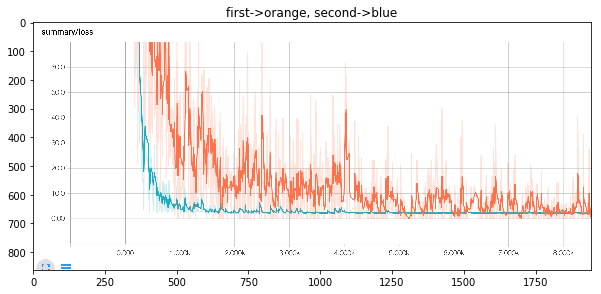

In [31]:
plt.figure(figsize=(10, 10))
img = plt.imread('../assets/Screen Shot 2017-11-02 at 9.23.18 PM.png')
plt.title('first->orange, second->blue')
plt.imshow(img)

In [27]:
tf.reset_default_graph()

N_CLASSES = 10

# Step 2: Define paramaters for the model
LEARNING_RATE = 0.01
BATCH_SIZE = 64
SKIP_STEP = 10
DROPOUT = 0.80
N_EPOCHS = 2


with tf.name_scope('data'):
    X = tf.placeholder(tf.float32, [None, 784], name="X_placeholder")
    Y = tf.placeholder(tf.float32, [None, 10], name="Y_placeholder")

dropout = tf.placeholder(tf.float32, name='dropout')

global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')


with tf.variable_scope('fc0') as scope:
    
    w = tf.get_variable('weights', shape=[784, 1024], initializer=tf.truncated_normal_initializer())
    b = tf.get_variable('bias', shape=[1024], initializer=tf.constant_initializer(0.0))
    
    fc0 = tf.nn.relu(tf.add(tf.matmul(X, w), b))
    

with tf.variable_scope('conv1') as scope:
    
    images = tf.reshape(fc0, shape=[-1, 32, 32, 1])
    
    
    kernel = tf.get_variable('kernel', shape=[5, 5, 1, 32], initializer=tf.truncated_normal_initializer())
    
   
    
    biases = tf.get_variable('biases', shape=[32], initializer=tf.constant_initializer(0.0))
    
   
    conv = tf.nn.conv2d(images, kernel, strides=[1, 1, 1, 1], padding='SAME')
    
   
    conv1 = tf.nn.relu(conv + biases, name='conv1')
    
    
    
with tf.variable_scope('pool1') as scope:
   
    
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], name='pool1', strides=[1, 2, 2, 1], padding='SAME')

    

with tf.variable_scope('conv2') as scope:

    kernel = tf.get_variable('kernels', [5, 5, 32, 64], 
                        initializer=tf.truncated_normal_initializer())
    biases = tf.get_variable('biases', [64],
                        initializer=tf.random_normal_initializer())
    conv = tf.nn.conv2d(pool1, kernel, strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(conv + biases, name=scope.name)


with tf.variable_scope('pool2') as scope:

    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                            padding='SAME')

   
    

with tf.variable_scope('fc') as scope:

    input_features = 8 * 8 * 64
    
   
    w = tf.get_variable('weights', shape=[input_features, 1024], initializer=tf.truncated_normal_initializer())
    b = tf.get_variable('bias', shape=[1024], initializer=tf.constant_initializer(0.0))

    pool2 = tf.reshape(pool2, [-1, input_features])

    fc = tf.nn.relu(tf.matmul(pool2, w) + b, name='relu')
    
   
    fc = tf.nn.dropout(fc, dropout, name='relu_dropout')

with tf.variable_scope('softmax_linear') as scope:
    
    w = tf.get_variable('weights', shape=[1024, N_CLASSES], initializer=tf.truncated_normal_initializer())
    b = tf.get_variable('bias', shape=[N_CLASSES], initializer=tf.constant_initializer(0.0))
    
    logits = tf.matmul(fc, w) + b


    
with tf.name_scope('loss'):
   
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits), name='loss')



optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss, global_step=global_step)

with tf.name_scope('summary'):
    tf.summary.scalar('loss', loss)
    summary_op = tf.summary.merge_all()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()

    writer = tf.summary.FileWriter('../my_graph/mnist3', sess.graph)
   
    
    initial_step = global_step.eval()

    start_time = time.time()
    n_batches = int(mnist.train.num_examples / BATCH_SIZE)

    total_loss = 0.0
    for index in range(initial_step, n_batches * N_EPOCHS): # train the model n_epochs times
        X_batch, Y_batch = mnist.train.next_batch(BATCH_SIZE)
        _, loss_batch, summary = sess.run([optimizer, loss, summary_op], 
                                feed_dict={X: X_batch, Y:Y_batch, dropout: DROPOUT}) 
        total_loss += loss_batch
        writer.add_summary(summary, global_step=index)
        if (index + 1) % SKIP_STEP == 0:
            print('Average loss at step {}: {:5.1f}'.format(index + 1, total_loss / SKIP_STEP))
            total_loss = 0.0
            saver.save(sess, '../checkpoints/convnet_mnist3/mnist-convnet', index)
    
    print("Optimization Finished!") # should be around 0.35 after 25 epochs
    print("Total time: {0} seconds".format(time.time() - start_time))
    
    # test the model
    n_batches = int(mnist.test.num_examples/BATCH_SIZE)
    total_correct_preds = 0
    for i in range(n_batches):
        X_batch, Y_batch = mnist.test.next_batch(BATCH_SIZE)
        _, loss_batch, logits_batch = sess.run([optimizer, loss, logits], 
                                        feed_dict={X: X_batch, Y:Y_batch, dropout: DROPOUT}) 
        preds = tf.nn.softmax(logits_batch)
        correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y_batch, 1))
        accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))
        total_correct_preds += sess.run(accuracy)   
    
    print("Accuracy {0}".format(total_correct_preds/mnist.test.num_examples))

Average loss at step 10: 1366590.3
Average loss at step 20: 80393.4
Average loss at step 30: 15991.7
Average loss at step 40: 9279.1
Average loss at step 50: 6295.8
Average loss at step 60: 4541.7
Average loss at step 70: 4650.9
Average loss at step 80: 3912.3
Average loss at step 90: 3518.4
Average loss at step 100: 3338.1
Average loss at step 110: 2680.4
Average loss at step 120: 2334.6
Average loss at step 130: 2413.0
Average loss at step 140: 2412.8
Average loss at step 150: 2226.1
Average loss at step 160: 2196.5
Average loss at step 170: 1962.1
Average loss at step 180: 1892.0
Average loss at step 190: 1497.8
Average loss at step 200: 1620.8
Average loss at step 210: 1621.5
Average loss at step 220: 1291.9
Average loss at step 230: 1322.8
Average loss at step 240: 1289.1
Average loss at step 250: 1153.8
Average loss at step 260: 1096.3
Average loss at step 270: 1088.2
Average loss at step 280: 1038.0
Average loss at step 290: 985.9
Average loss at step 300: 875.0
Average loss at 

# (2 epochs) one fc with relu then 2 conv nets then 1 fc with dropout  -> Accuracy 0.1285 :(

# try resnet

In [34]:
tf.reset_default_graph()

N_CLASSES = 10

# Step 2: Define paramaters for the model
LEARNING_RATE = 0.01
BATCH_SIZE = 64
SKIP_STEP = 10
DROPOUT = 0.80
N_EPOCHS = 2


with tf.name_scope('data'):
    X = tf.placeholder(tf.float32, [None, 784], name="X_placeholder")
    Y = tf.placeholder(tf.float32, [None, 10], name="Y_placeholder")

dropout = tf.placeholder(tf.float32, name='dropout')

global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')


with tf.variable_scope('fc0') as scope:
    
    w = tf.get_variable('weights', shape=[784, 1024], initializer=tf.truncated_normal_initializer())
    b = tf.get_variable('bias', shape=[1024], initializer=tf.constant_initializer(0.0))
    
    fc0 = tf.nn.relu(tf.add(tf.matmul(X, w), b))
    
with tf.variable_scope('fc1') as scope:
    
    w = tf.get_variable('weights', shape=[1024, 784], initializer=tf.truncated_normal_initializer())
    b = tf.get_variable('bias', shape=[784], initializer=tf.constant_initializer(0.0))
    
    fc1 = tf.add(tf.nn.relu(tf.add(tf.matmul(fc0, w), b)), X)
    

with tf.variable_scope('conv1') as scope:
    
    images = tf.reshape(fc1, shape=[-1, 28, 28, 1])
    
    
    kernel = tf.get_variable('kernel', shape=[5, 5, 1, 32], initializer=tf.truncated_normal_initializer())
    
   
    
    biases = tf.get_variable('biases', shape=[32], initializer=tf.constant_initializer(0.0))
    
   
    conv = tf.nn.conv2d(images, kernel, strides=[1, 1, 1, 1], padding='SAME')
    
   
    conv1 = tf.nn.relu(conv + biases, name='conv1')
    
    
    
with tf.variable_scope('pool1') as scope:
   
    
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], name='pool1', strides=[1, 2, 2, 1], padding='SAME')

    

with tf.variable_scope('conv2') as scope:

    kernel = tf.get_variable('kernels', [5, 5, 32, 64], 
                        initializer=tf.truncated_normal_initializer())
    biases = tf.get_variable('biases', [64],
                        initializer=tf.random_normal_initializer())
    conv = tf.nn.conv2d(pool1, kernel, strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(conv + biases, name=scope.name)


with tf.variable_scope('pool2') as scope:

    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                            padding='SAME')

   
    

with tf.variable_scope('fc') as scope:

    input_features = 7 * 7 * 64
    
   
    w = tf.get_variable('weights', shape=[input_features, 1024], initializer=tf.truncated_normal_initializer())
    b = tf.get_variable('bias', shape=[1024], initializer=tf.constant_initializer(0.0))

    pool2 = tf.reshape(pool2, [-1, input_features])

    fc = tf.nn.relu(tf.matmul(pool2, w) + b, name='relu')
    
   
    fc = tf.nn.dropout(fc, dropout, name='relu_dropout')

with tf.variable_scope('softmax_linear') as scope:
    
    w = tf.get_variable('weights', shape=[1024, N_CLASSES], initializer=tf.truncated_normal_initializer())
    b = tf.get_variable('bias', shape=[N_CLASSES], initializer=tf.constant_initializer(0.0))
    
    logits = tf.matmul(fc, w) + b


    
with tf.name_scope('loss'):
   
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits), name='loss')



optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss, global_step=global_step)

with tf.name_scope('summary'):
    tf.summary.scalar('loss', loss)
    summary_op = tf.summary.merge_all()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()

    writer = tf.summary.FileWriter('../my_graph/mnist4', sess.graph)
   
    
    initial_step = global_step.eval()

    start_time = time.time()
    n_batches = int(mnist.train.num_examples / BATCH_SIZE)

    total_loss = 0.0
    for index in range(initial_step, n_batches * N_EPOCHS): # train the model n_epochs times
        X_batch, Y_batch = mnist.train.next_batch(BATCH_SIZE)
        _, loss_batch, summary = sess.run([optimizer, loss, summary_op], 
                                feed_dict={X: X_batch, Y:Y_batch, dropout: DROPOUT}) 
        total_loss += loss_batch
        writer.add_summary(summary, global_step=index)
        if (index + 1) % SKIP_STEP == 0:
            print('Average loss at step {}: {:5.1f}'.format(index + 1, total_loss / SKIP_STEP))
            total_loss = 0.0
            saver.save(sess, '../checkpoints/convnet_mnist4/mnist-convnet', index)
    
    print("Optimization Finished!") # should be around 0.35 after 25 epochs
    print("Total time: {0} seconds".format(time.time() - start_time))
    
    # test the model
    n_batches = int(mnist.test.num_examples/BATCH_SIZE)
    total_correct_preds = 0
    for i in range(n_batches):
        X_batch, Y_batch = mnist.test.next_batch(BATCH_SIZE)
        _, loss_batch, logits_batch = sess.run([optimizer, loss, logits], 
                                        feed_dict={X: X_batch, Y:Y_batch, dropout: DROPOUT}) 
        preds = tf.nn.softmax(logits_batch)
        correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y_batch, 1))
        accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))
        total_correct_preds += sess.run(accuracy)   
    
    print("Accuracy {0}".format(total_correct_preds/mnist.test.num_examples))

Average loss at step 10: 17788824.2
Average loss at step 20: 1083870.6
Average loss at step 30: 197865.6
Average loss at step 40: 94776.7
Average loss at step 50: 63273.8
Average loss at step 60: 50003.1
Average loss at step 70: 37653.5
Average loss at step 80: 35214.1
Average loss at step 90: 31107.0
Average loss at step 100: 26878.4
Average loss at step 110: 23883.7
Average loss at step 120: 22298.1
Average loss at step 130: 20411.6
Average loss at step 140: 15411.7
Average loss at step 150: 15745.3
Average loss at step 160: 13657.7
Average loss at step 170: 11996.5
Average loss at step 180: 9973.1
Average loss at step 190: 9951.5
Average loss at step 200: 8184.6
Average loss at step 210: 7711.6
Average loss at step 220: 5708.9
Average loss at step 230: 4484.7
Average loss at step 240: 3318.9
Average loss at step 250: 3143.7
Average loss at step 260: 2811.9
Average loss at step 270: 2501.5
Average loss at step 280: 1573.3
Average loss at step 290: 1809.6
Average loss at step 300: 133

# (2 epochs) fc then fc with resnet with relu then 2 conv nets then 1 fc with dropout -> Accuracy 0.1399 :(